In [17]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from functions import plot_formation
plt.style.use('matplotlibrc')
import matplotlibcolors
from matplotlib.lines import Line2D
colors = ['b', 'o', 'y', 'p', 'g', 'lb', 'r']

%matplotlib widget

# Import data and set variables

In [2]:
mat_file_path = './FC_data/data.mat'
mat_data = scipy.io.loadmat(mat_file_path)
K = 10000                                       # number of iterations
T = 100                                         # number of noisy measurements                              
L = mat_data['L']                               # NxN edge weights
M = 12                                          # number of edges
N = 7                                           # number of agents
R = mat_data['R']                               # covariance matrix
dt = 0.05                                       # timestep
z0 = mat_data['z']                              # Nx2 actual positions 
z0[:3, 0] -= .5
z_star = np.array(mat_data['z_star'], dtype=float) # Nx2 target positions
z_star[:, 0] -= 0.5
D = z_star.shape[1]                             # number of dimensions

# Control theory

Theorem 3.3 from the thesis explained that for a $R^D$ dimension space you need at leest $D+1$ leader agents whose position does not change.

In [3]:
def formation(add_noise=True, estimator='mean'):
    z = np.ones((N, D, K))*z0.reshape(N, D, 1)
    k = 0
    while k < K-1:
        for i in range(3, N):
            z_i = z[i, :, k]                    # current position
            z_j = z[:, :, k]                    # all positions
            dz = (z_i - z_j).reshape(N, D, 1)   # relative positions

            if add_noise:
                v = np.random.multivariate_normal([0, 0], R, (N,T)).reshape(N, D, T)     # measurement noise v ~ N(0, R)
                y = dz + v                  # linear Gaussian model
            else:
                y = dz

            if estimator =='None':           
                est = y[:, :, 0]         # no estimator: first measurement is used
            elif estimator == 'mean':
                est = np.mean(y, axis=2)  # estimator 1: mean of measurements
            elif estimator == 'min':
                est = np.amin(y, axis=2)  # estimator 2: minimum of measurements
            elif estimator == 'max':
                est = np.amax(y, axis=2)  # estimator 3: maximum of measurements
            u = np.dot(L[i], est)
            # possibility to add process noise w  ~ squared exponential
            z[i, :, k+1] = z_i + dt * u
        k += 1
    return z
        

# Results

### Compute formations

In [4]:
z_nonoise = formation(add_noise=False)
z_none = formation(estimator='None')
z_mean = formation(estimator='mean')
z_min = formation(estimator='min')

### Compute error in formation

In [22]:
zs = [z_nonoise, z_none, z_mean, z_min]
labels = ['Noiseless', 'No estimator', 'Least squares estimator', 'Minimum estimator']
errors = []
for i, z in enumerate(zs):
    errors.append(np.sum(np.linalg.norm(z-z_star.reshape((N,D,1)), axis=1), axis=0))

### Compute effect of T

In [6]:
Ts = [1, 10, 100, 1000]             
zs_Ts = []
errors_Ts = []
for T in Ts:
    zs_Ts.append(formation(estimator='mean'))
for i, z in enumerate(zs_Ts):
    errors_Ts.append(np.sum(np.linalg.norm(z-z_star.reshape((N,D,1)), axis=1), axis=0))

The case of the least square estimator with T=1 is actually the same as having no estimator

# Figures

### Plot various formations for different estimators

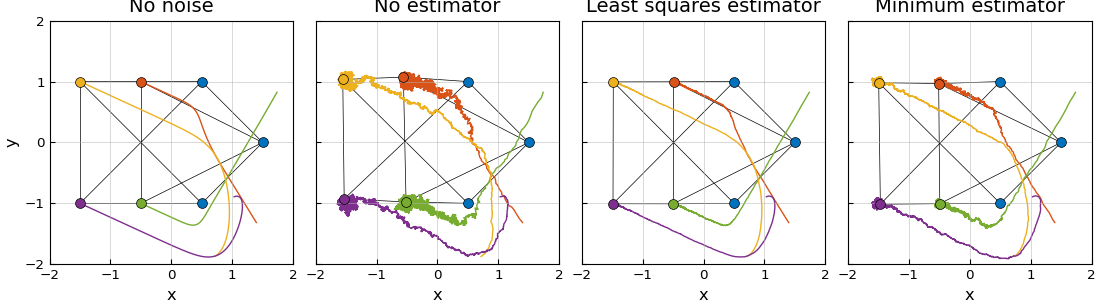

In [7]:
fig, axes = plt.subplot_mosaic('abcd', figsize=(11,3), constrained_layout=True, sharey=True, sharex=True)
for i, ax_id in enumerate(axes):
    ax = axes[ax_id]
    ax.grid(True, which='major')
    plot_formation(zs[i], ax)
    axlim = [-2,2]
    ax.set_xlim(axlim)
    ax.set_ylim(axlim)
    ax.set_xlabel('x')
    ax.set_title(labels[i])
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(axlim[0], axlim[1]+1, 1))
    ax.set_yticks(np.arange(axlim[0], axlim[1]+1, 1))
_ = axes['a'].set_ylabel('y')

### Plot formation error for various estimators

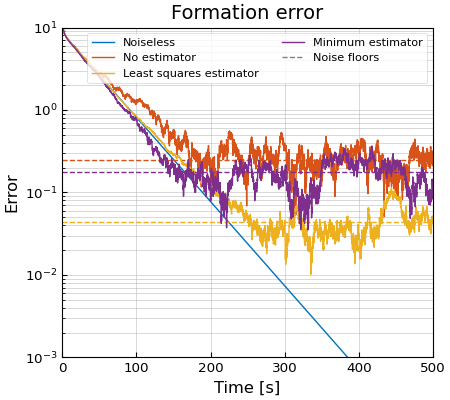

In [24]:
fig, axes = plt.subplot_mosaic('a', figsize=(4.5,4), constrained_layout=True)
ax = axes['a']
time = np.linspace(0, (K-1)*dt, K)
for i, z in enumerate(zs):
    error = errors[i]
    noise_floor = np.mean(error[time > 300])
    ax.semilogy(time, error, label=labels[i])
    if i > 0:
        ax.axhline(noise_floor, c=colors[i],  ls='--')
ax.legend()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Error')
ax.set_title('Formation error')
ax.set_xlim([0, 500])
ax.set_ylim([1e-3, 1e1])
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0], color='gray', linestyle='--', label='Noise floors'))
_ = ax.legend(handles=handles, loc='upper right', ncols=2)

### Plot formation error for different T

In [9]:
def one_over_root(x, a):
    return a/np.sqrt(x)

def linear(x, b):
    return -.5*x+b

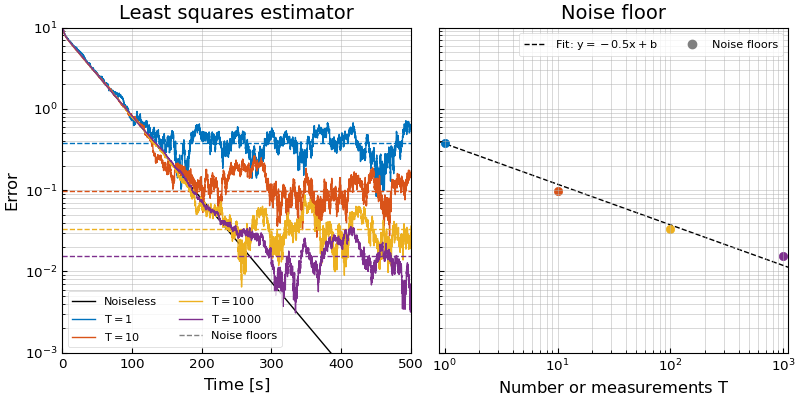

In [25]:


fig, axes = plt.subplot_mosaic('ab', figsize=(8,4), constrained_layout=True, sharey=True)
time = np.linspace(0, (K-1)*dt, K)
noise_floors = []
ax = axes['a']
ax.semilogy(time, errors[0], c='k' , label='Noiseless')
for i, z in enumerate(zs_Ts):
    error = errors_Ts[i]
    noise_floors.append(np.mean(error[time > 300]))
    ax.semilogy(time, error, label='$T=%d$' % Ts[i])
    ax.axhline(noise_floors[-1], c=colors[i],  ls='--')
ax.set_xlabel('Time [$s$]')
ax.set_ylabel('Error')
ax.set_title('Least squares estimator')
ax.set_xlim([0, 500])
ax.set_ylim([1e-3, 1e1])
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0], color='gray', linestyle='--', label='Noise floors'))
_ = ax.legend(handles=handles, loc='lower left', ncols=2)

ax = axes['b']
plot_Ts = np.linspace(.9, 1100)
popt, pcov = curve_fit(linear, np.log10(Ts), np.log10(noise_floors))
perr = np.sqrt(np.diag(pcov))
ax.loglog(plot_Ts, one_over_root(plot_Ts, 10**popt[0]), 'k--', zorder=0, label='Fit: $ y=-0.5x+b$' )
for i, T in enumerate(Ts):
    ax.scatter(T, noise_floors[i], color=colors[i], zorder=1)
ax.legend()
ax.set_xlabel('Number or measurements $T$')
# ax.set_ylabel('Noise floor')
ax.set_title('Noise floor')
ax.set_xlim([.9e0, 1.1e3])
ax.set_ylim([1e-3, 1e1])
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0], color='gray', linestyle='None', marker='o' , label='Noise floors'))
_ = ax.legend(handles=handles, loc='upper right', ncols=2)

It is clearly seen that the noise floor scales with y=-.5x+b in loglog, so the noise floor scales with 1/sqrt(T)